# Отбор признаков, влияние порога классификации на качество модели и выбор метрики качества модели на оценки бизнес-метрики

Компания «Морские гады» доставляет корпоративным клиентам блюда из морепродуктов. На прибыль сильно влияет отмена заказов, потому что их не оплачивают, а товар приходится выбрасывать. Морепродукты нельзя замораживать повторно, иначе портится вкус. Менеджмент задумал отбивать себестоимость и ввести предоплату, но для этого необходима модель, которая будет предсказывать отмену заказов.

Менеджмент задумал отбивать себестоимость и ввести предоплату, но осторожно. Опыт показывает, что эта мера отпугивает 20% клиентов. Решено запрашивать предоплату 70% в тех случаях, когда есть явный риск отмены заказа. Вам нужно научиться предсказывать такие случаи. При этом важно сэкономить больше 890 тыс. рублей, чтобы окупить затраты на новое решение.

«Морские гады» предоставили датасет за последние несколько месяцев. Владелец данных предупредил: "Бизнес небольшой, поэтому информации мало. Клиенты и заказы бывают разные. Нужна модель, которая сможет делать предсказания для любых случаев."

Такие вводные означают, что нужно учесть все данные. Удалять нетипичные объекты из признакового описания нельзя.

Датасет содержит следующие поля:
* `client_id` — идентификатор клиента;
* `reject_count` — количество отменённых заказов за всю историю;
* `confirm_count` — количество подтверждённых заказов;
* `last_summ` — сумма, полученная от клиента за всю историю;
* `summ_`— стоимость последнего заказа клиента;
* `count_position` — число позиций в последнем заказе;
* `target` — заказ отменён (1), заказ подтверждён (0).


## Подготовка данных

In [2]:
# Загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint, randrange
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Загрузим необходимые модели для классификации и метрики качества
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, RocCurveDisplay
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.utils import shuffle
from mlxtend.plotting import plot_decision_regions
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 123

import os

In [21]:
# Прочитаем файл с данными в переменную df и изучим их
os.chdir(r"C:\Users\pasht\OneDrive\Документы\4 курс 1 семестр\искусственный интелект в прикладных задачах\задание 4")
df = pd.read_csv('orders_seafood.csv')
df

,client_id,reject_count,confirm_count,last_summ,summ_,count_position,target
0,8195,27,13,132684.4,34875.3,18,1
1,16392,29,15,149790.1,19537.4,11,1
2,16396,25,17,80195.2,44583.0,23,1
3,8206,22,10,80089.5,22561.6,15,1
4,16398,14,14,163565.6,27986.4,17,1
...,...,...,...,...,...,...,...
745,1401,13,13,77436.3,4503.7,3,0
746,1403,15,177,165176.1,4610.0,3,0
747,9596,15,17,135085.4,12553.7,6,0
748,9598,12,15,137887.6,4803.0,3,0


In [23]:
# первые 5 строк датасета
df.head()

,client_id,reject_count,confirm_count,last_summ,summ_,count_position,target
0,8195,27,13,132684.4,34875.3,18,1
1,16392,29,15,149790.1,19537.4,11,1
2,16396,25,17,80195.2,44583.0,23,1
3,8206,22,10,80089.5,22561.6,15,1
4,16398,14,14,163565.6,27986.4,17,1


In [27]:
# Общая информация о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       750 non-null    int64  
 1   reject_count    750 non-null    int64  
 2   confirm_count   750 non-null    int64  
 3   last_summ       750 non-null    float64
 4   summ_           750 non-null    float64
 5   count_position  750 non-null    int64  
 6   target          750 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 41.1 KB


In [31]:
# Проверка наличия дубликатов
df.duplicated().sum()

0

Всего имеем 750 записей, пропусков и дубликатов нет, типы данных соответствуют хранимым сведениям

In [33]:
# Изучим числовые характеристики признаков методом describe
df.describe()

,client_id,reject_count,confirm_count,last_summ,summ_,count_position,target
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,8911.952000,20.524000,43.281333,117236.968533,13642.938933,8.010667,0.700000
std,6815.642179,6.190896,55.671117,33535.611602,11264.546470,6.231184,0.458563
min,25.000000,5.000000,5.000000,32896.400000,1460.100000,1.000000,0.000000
25%,1030.250000,16.000000,14.000000,98092.800000,5028.400000,3.000000,0.000000
50%,8928.000000,21.000000,17.000000,120045.100000,8134.700000,5.000000,1.000000
75%,16768.000000,25.000000,24.750000,142483.850000,22788.950000,13.000000,1.000000
max,17776.000000,39.000000,204.000000,191564.800000,69465.900000,30.000000,1.000000


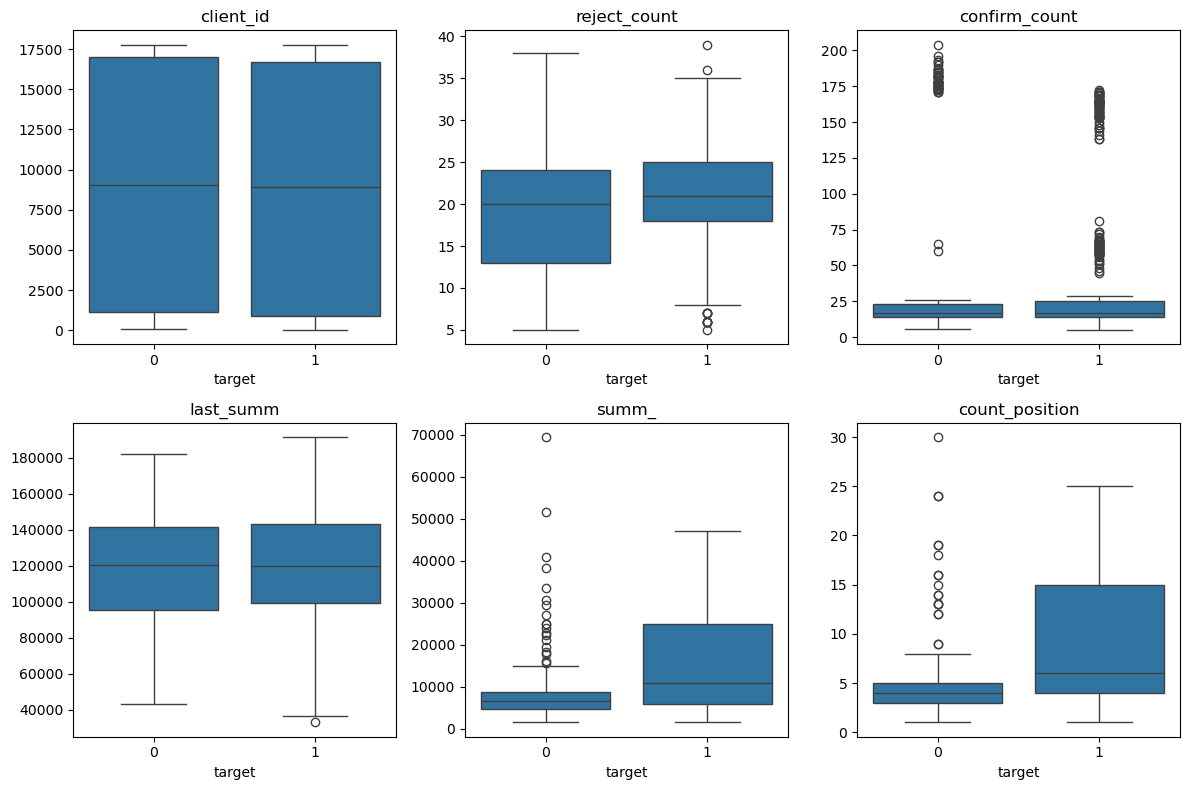

In [35]:
# Построим диаграммы размаха признаков в разрезе признака отказа от заказа

fig, axes = plt.subplots(2,3,figsize=(12,8))

for i, ax in enumerate(axes.flatten()):

    sns.boxplot(data = df, x = 'target', y = df.columns[i], ax=ax)

    ax.set_ylabel(None)
    ax.set_title(label=df.columns[i])
plt.tight_layout()

Для отмененных заказов сумма заказа и количество позиций в заказе выше, чем для подтвержденных заказов.

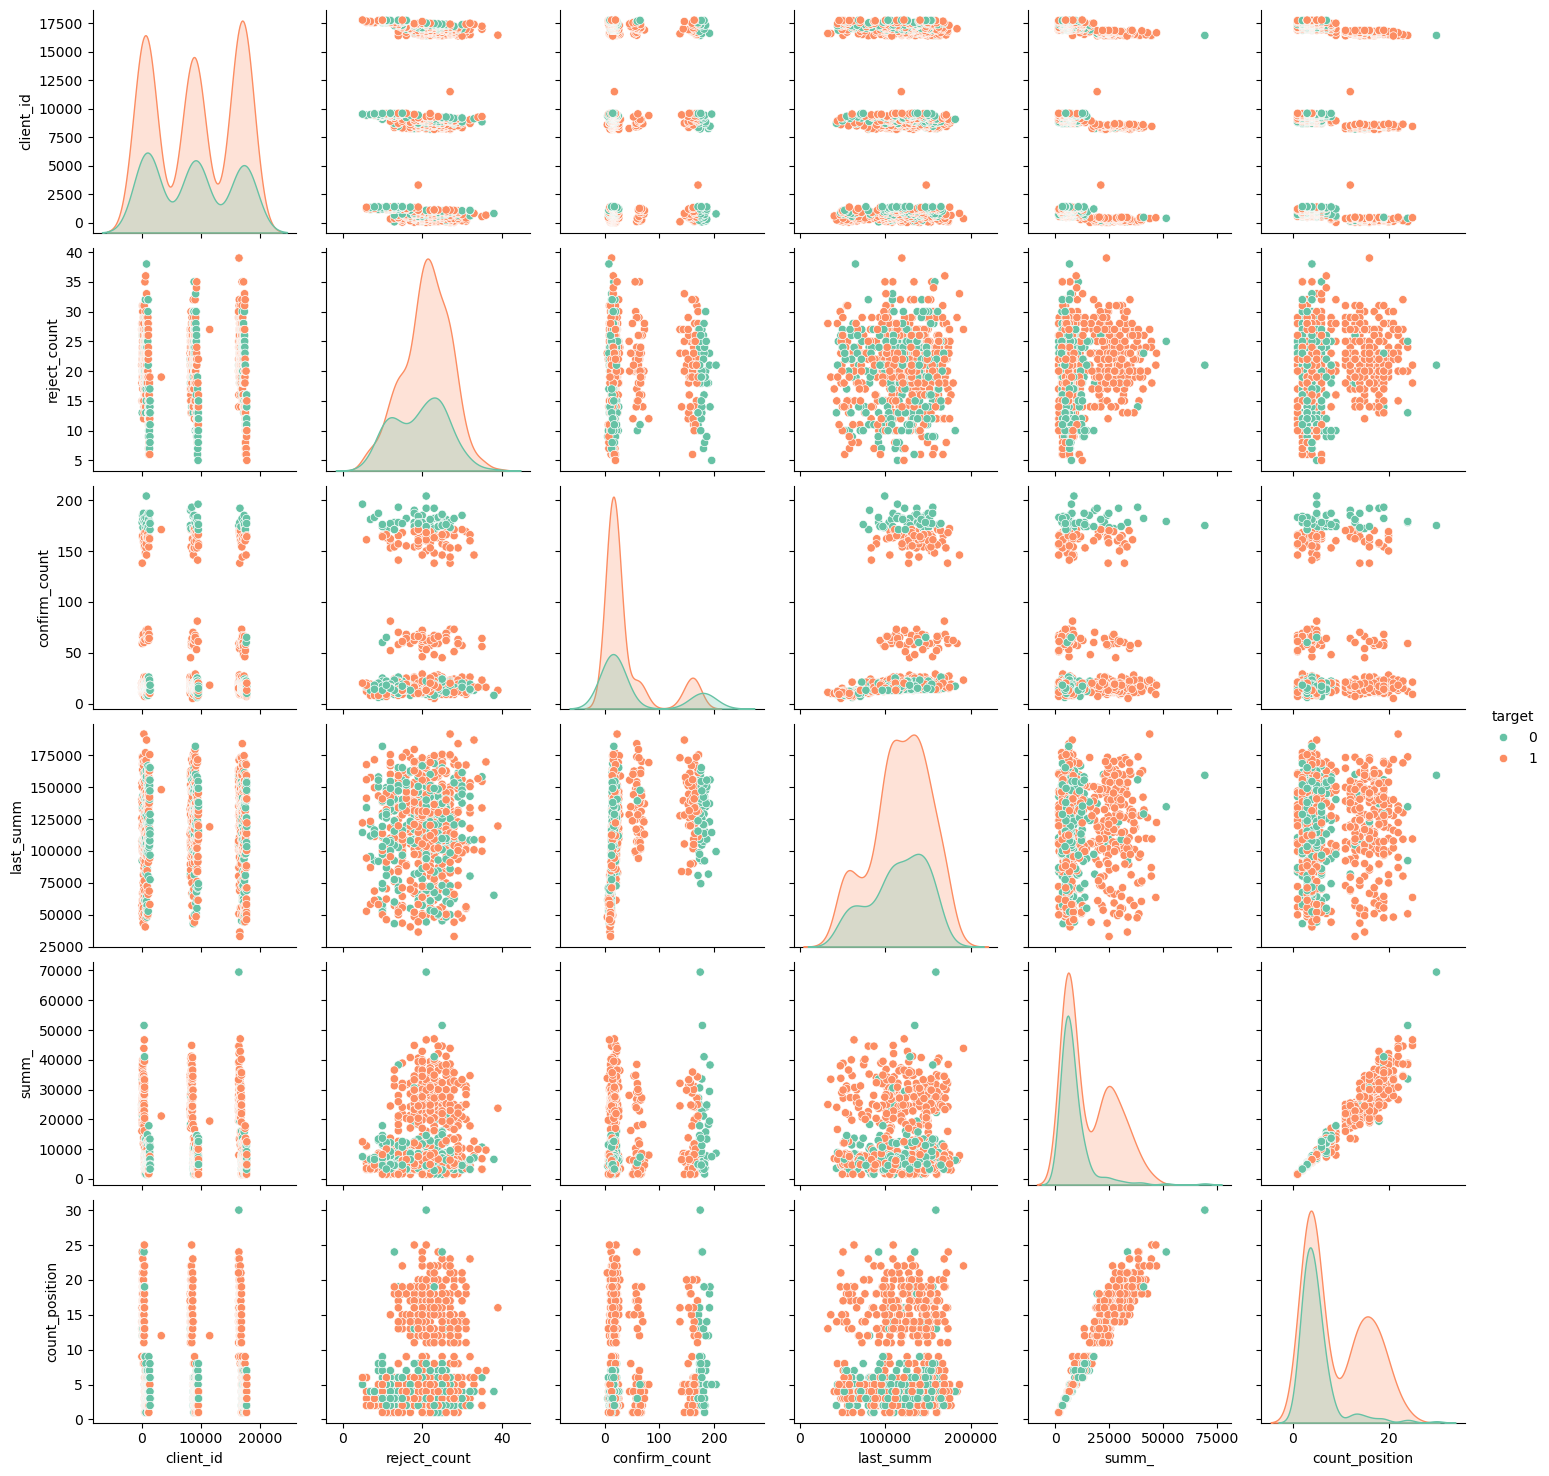

In [37]:
# Построим диаграммы рассеяния методом pairplot в разрезе признака target
sns.set_palette('Set2')

sns.pairplot(df, hue = 'target')
plt.show()

Как видим, ни на одном из изображений нет чёткой границы между отменёнными заказами — оранжевыми кружками — и подтверждёнными — кружками зелеными. Каждый зеленый кружок среди большого количества оранжевых — и наоборот — это и есть свидетельство нестандартной комбинации признаков. Необычные значения целевого признака будут мешать линейной модели учиться. Эти значения будет сложно предсказать.

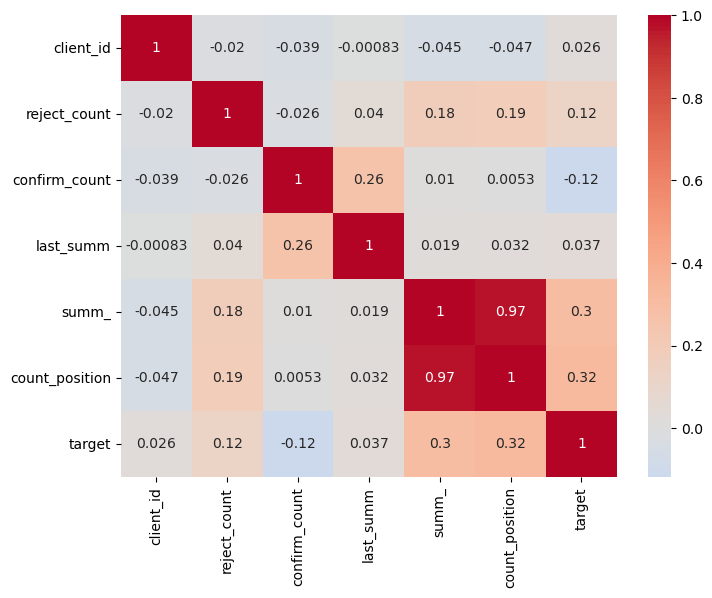

In [39]:
# Построим тепловую карту матрицы парных коэффициентов корреляции
plt.figure(figsize=(8,6))


sns.heatmap(df.corr(), annot= True, cmap = 'coolwarm', center = 0)

plt.show()

Линейные связи достатточно слабые между всеми признаками. Наиболее тесную линейную связь можно наблюдать между целевым признаком и количеством позиций в заказе и суммой этого заказа. При этом видим наличие очень тесной связи между этими признаками (количеством позиций в заказе и суммой заказа). При построении модели логистической регрессии следует учесть коллинеарность факторов.

In [43]:
# Оценим баланс классов

df['target'].value_counts(normalize = True)


target
1    0.7
0    0.3
Name: proportion, dtype: float64

Видим дисбаланс классов, поэтому для обучения моделей будем использовать взвешивание классов.

Для обучения моделей выделим целевой признак и факторы.

In [54]:
X = df.drop(columns = ['target', 'client_id'])
y =df['target']

In [56]:
X.head()

,reject_count,confirm_count,last_summ,summ_,count_position
0,27,13,132684.4,34875.3,18
1,29,15,149790.1,19537.4,11
2,25,17,80195.2,44583.0,23
3,22,10,80089.5,22561.6,15
4,14,14,163565.6,27986.4,17


Разделим выборку на тренировочную и тестовую в соотношении 75:25. Используем метод `train_test_split`. Выборку для валидации выделять не будем, т.к. для подбора гиперпараметров моделей рассмотрим процедуру кросс-валидации.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y)


In [66]:
# Для интерпретации модели логистической регрессии нормализуем данные
# Обучим и преобразуем количественные признаки из тренировочной и тестовой выборок
# для тренировочной выборки выполним действия одной командой

scaler = StandardScaler()
X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)


## Логистическая регрессия

In [70]:
# Инициируем класс логистической регрессии и обучим модель на стандартизованных данных

logreg = LogisticRegression(class_weight = 'balanced', random_state = 123).fit(X_train_scalled, y_train)

# Построим прогноз на тестовой выборке

y_pred = logreg.predict(X_test_scalled)

# Вычислим метрику accuracy на тестовой выборке
acc = accuracy_score(y_test, y_pred)
acc

0.5957446808510638

Точность не очень высокая, но вдруг точности в 59.6% достаточно, чтобы выполнить запрос бизнеса и сэкономить 1 млн рублей?

Для проверки предлагаем сделать приблизительный расчёт на валидационной выборке:
* **Сначала вычислить, сколько компании удалось бы сберечь благодаря модели.** Для этого нужно умножить стоимость отменённых заказов, которые удалось предсказать, на 70% — размер предоплаты. Но важно учесть, что 20% клиентов из-за нового требования изначально не оформили бы заказ — соответственно, предоплату не внесли бы. Поэтому рассчитанную сумму выгоды нужно умножить ещё и на 80%, чтобы её уточнить. То есть слегка уменьшить.
* **Потом найти сумму, которую компания потеряла бы из-за модели.** Чтобы её выяснить, тоже важна статистика об уходе 20% клиентов из-за запроса на предоплату. Надо умножить на 20% стоимость заказов, отмена которых не подтвердилась. Ведь их могли бы оплатить, если бы никого не смутило новое требование.
* **Вычесть из сбережённой суммы объём потерь.**

In [72]:
# создаём таблицы для подсчёта средств, которые удалось сэкономить

predicts = X_test[['summ_']]
predicts['y_pred'] = y_pred
predicts['y_test'] = y_test

TP = predicts[(predicts['y_pred']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
FP = predicts[(predicts['y_pred']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

money = TP-FP
money

873692.6520000001

С построенной моделью для наблюдений валидационной выборки получилось сэкономить около 873 тыс. рублей. Чтобы окупить расходы на внедрение машинного обучения, надо «выиграть» больше.

### Настройка модели

Попробуем повысить качество и финансовую эффективность модели с помощью порогов

In [ ]:
# Определим значение порога классификатора от 0.1 до 1, разделив отрезок [0.1; 1] на 18 частей
thresholds = [round(i,2) for i in np.linspace(0.1,1,num = 18, endpoint=False)]

y_proba_log = logreg.predict_proba(X_test_scalled)[:,1]

for i in thresholds:
    y_pred_log = []
    for j in y_proba_log:
        if j<i:
            y_pred_log.append(0)
        else:
            y_pred_log.append(1)
    predicts = pd.DataFrame(zip(y_pred_log, y_test,  X_test['summ_'].tolist()), \
                        columns = ['y_pred', 'y_test', 'summ_'])

    TP = predicts[(predicts['y_pred']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
    FP = predicts[(predicts['y_pred']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2
    money = TP-FP

    # Выведем результат сэкономленных средств при различных уровнях порога
    print('threshold: ', i, '   money: ', round(money, 3))



threshold:  0.1    money:  1014582.544
threshold:  0.15    money:  1014205.536
threshold:  0.2    money:  1004317.788
threshold:  0.25    money:  1000243.964
threshold:  0.3    money:  994332.312
threshold:  0.35    money:  977071.348
threshold:  0.4    money:  955368.576
threshold:  0.45    money:  921148.808
threshold:  0.5    money:  873692.652
threshold:  0.55    money:  856194.992
threshold:  0.6    money:  810183.684
threshold:  0.65    money:  773821.776
threshold:  0.7    money:  740061.224
threshold:  0.75    money:  725884.88
threshold:  0.8    money:  588922.824
threshold:  0.85    money:  376728.072
threshold:  0.9    money:  199700.76
threshold:  0.95    money:  36408.344


Сколько удалось сэкономить с настроенной моделью? Похоже, что пороги приближают результат к желаемому, но всё-таки не спасают ситуацию.

### Регуляризация

Посмотрим на коэффициенты базовой модели перед настройкой регуляризации.

In [78]:
coeff = pd.DataFrame(logreg.coef_, columns = X_train.columns)
coeff

,reject_count,confirm_count,last_summ,summ_,count_position
0,0.121037,-0.465585,0.152819,-0.431261,1.382514


В модели по умолчанию выбрана `L2`-регуляризация и `C=1`. Что будет, если сильно увеличить `C` и тем самым сократить штраф?

In [88]:
clf_ridge = LogisticRegression(penalty = 'l2', C = 15, class_weight = 'balanced', random_state = 123).fit(X_train_scalled, y_train)

y_pred = clf_ridge.predict(X_test_scalled)

# Вычисляем метрику accuracy
acc = accuracy_score(y_test, y_pred)
acc


0.601063829787234

Посмотрим, как изменились коэффициенты регрессии

In [94]:
coeff = pd.DataFrame(logreg.coef_, columns = X_train.columns)
coeff

,reject_count,confirm_count,last_summ,summ_,count_position
0,0.121037,-0.465585,0.152819,-0.431261,1.382514


Качество незначительно увеличилось, а коэффициенты немного изменились — особенно у последних двух признаков.

Посмотрим, поможет ли модель с такими настройками сэкономить деньги:

In [96]:
predicts = X_test[['summ_']].copy()
predicts['LR_reg'] = y_pred
predicts['y_test'] = y_test

TP = predicts[(predicts['LR_reg']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
FP = predicts[(predicts['LR_reg']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

money = TP-FP
money

876203.3920000001

Удалось немного улучшить результат.

Возможно, есть такие коэффициенты, которые стоит убрать.

Обучим модель логистической регрессии с `L1`-регуляризацией и `C=0.1`. Выведите на экран значение `accuracy` и коэффициенты модели.

In [102]:
# обучите модель логистической регрессии, используйте L1-регуляризацию
clf_lasso = LogisticRegression(penalty = 'l1', C = 0.1, class_weight = 'balanced', random_state = 123, solver='liblinear').fit(X_train_scalled, y_train)

y_pred = clf_ridge.predict(X_test_scalled)

# Вычисляем метрику accuracy
acc = accuracy_score(y_test, y_pred)
acc





0.601063829787234

In [110]:
# Коэффициенты регрессии
coeff = pd.DataFrame(clf_lasso.coef_, columns = X_train.columns)
coeff

,reject_count,confirm_count,last_summ,summ_,count_position
0,0.059882,-0.325915,0.039173,0.0,0.789394


Посмотрим, поможет ли модель с такими настройками сэкономить деньги:

In [108]:
predicts = X_test[['summ_']].copy()
predicts['LR_reg'] = y_pred
predicts['y_test'] = y_test

TP = predicts[(predicts['LR_reg']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
FP = predicts[(predicts['LR_reg']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

money = TP-FP
money

876203.3920000001

`L1`-регуляризация не помогла.

## Метод опорных векторов

In [114]:
# Инициируем модель опорных векторов и обучим модель на стандартизованных данных
svc = SVC(class_weight = 'balanced').fit(X_train_scalled, y_train)

# Построим прогноз на валидационной выборке

y_pred = svc.predict(X_test_scalled)

# Вычислим метрику accuracy на валидационной выборке
acc = accuracy_score(y_test,y_pred)
acc

0.6542553191489362

Прирост налицо: качество у логистической регрессии было 0.6. Посчитаем, сколько денег сэкономит новая модель

In [116]:
# создаём таблицы для подсчёта средств, которые удалось сэкономить
predicts = X_test[['summ_']].copy()
predicts['SVM'] = y_pred
predicts['y_test'] = y_test

TP = predicts[(predicts['SVM']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
FP = predicts[(predicts['SVM']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2
money = TP-FP

money

835751.7160000001

Теперь разберёмся, как выглядит разделяющая гиперплоскость, которая помогла нам так хорошо классифицировать данные.

### Визуализация построенной разделяющей гиперплоскости

Разделим данные на пары признаков и посмотрим, как классификатор принимает решение

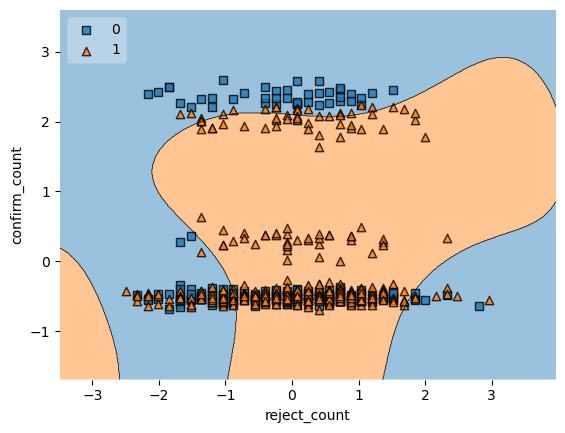

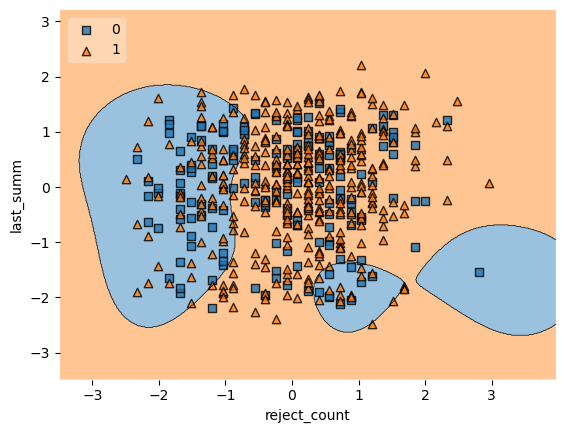

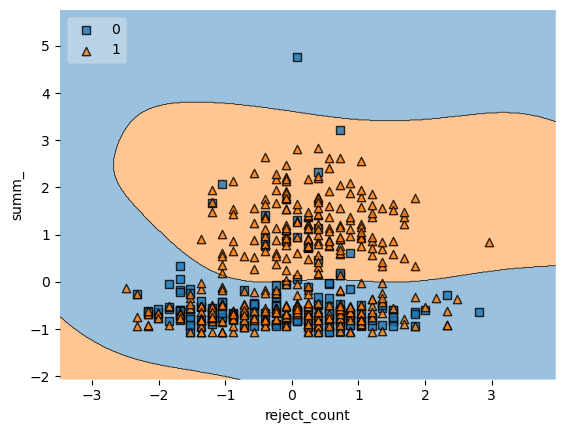

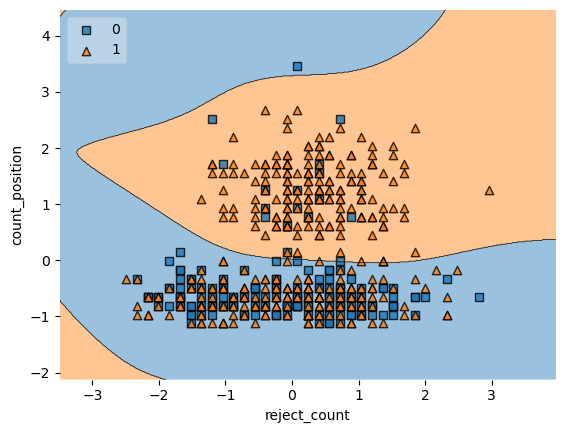

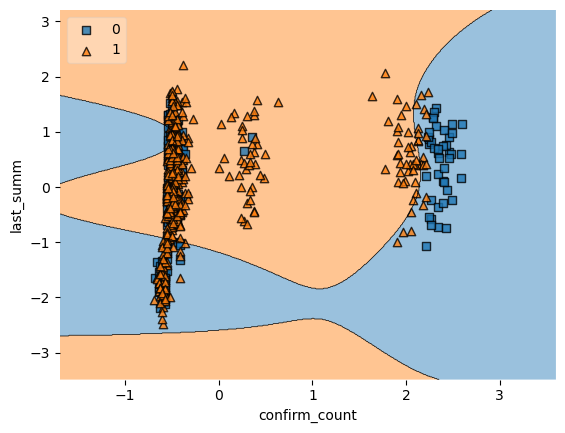

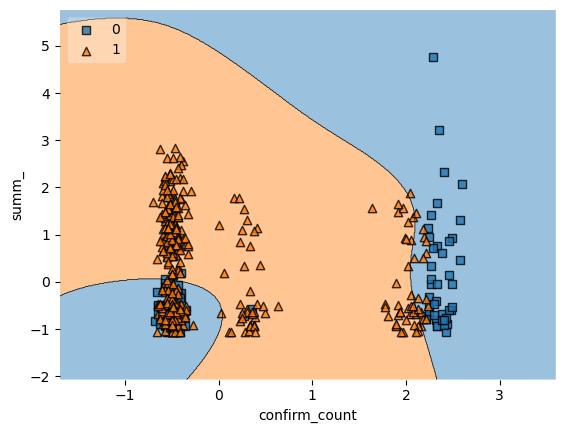

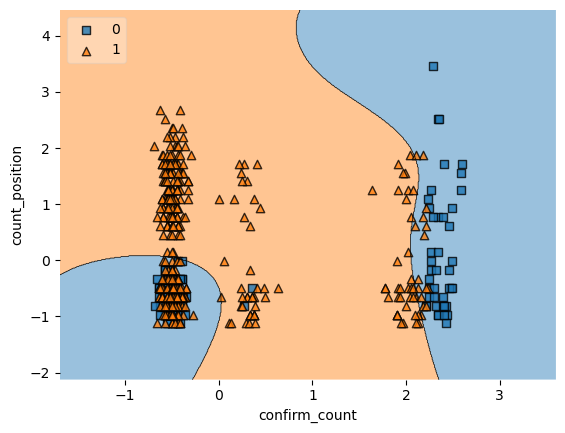

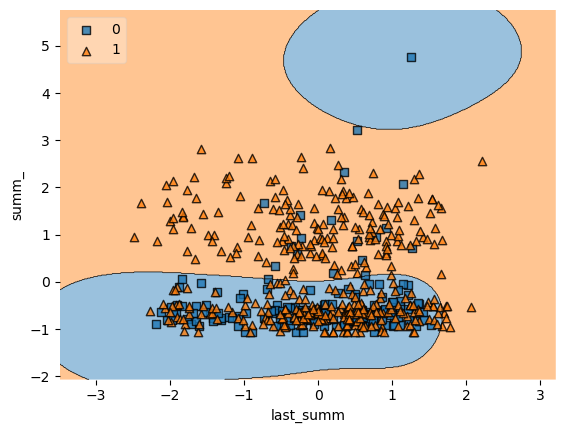

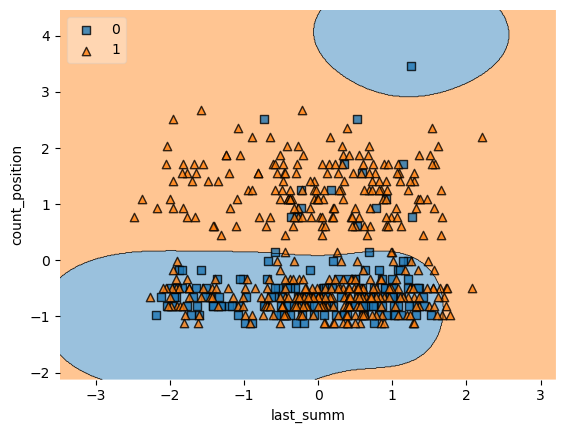

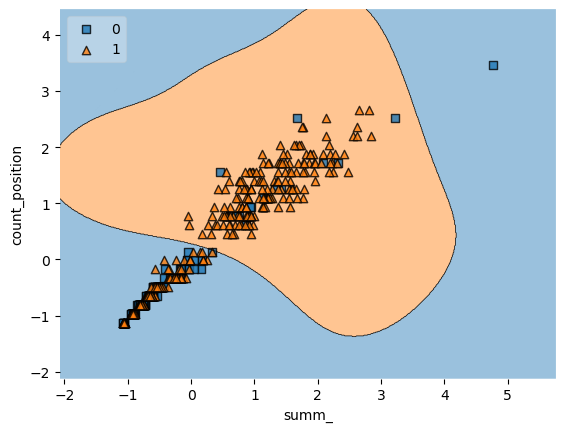

In [118]:
# генерируем варианты разбивки признаков на пары без повторений
columns = list(X_train.columns)
all_variants = list(combinations(columns, 2))

# создаём и обучаем модель — она обучается на паре признаков и строит
# для них разделяющую границу
for i in range(len(all_variants)):
    model = SVC(class_weight = 'balanced')
    X_new_train = X_train[[all_variants[i][0], all_variants[i][1]]]
    X_new_scalled = scaler.fit_transform(X_new_train)
    model.fit(X_new_scalled, y_train)
    a = plot_decision_regions(X_new_scalled, y_train.to_numpy(), clf=model, legend=2)
    plt.xlabel(all_variants[i][0])
    plt.ylabel(all_variants[i][1])
    plt.show()

### Настройки SVM

Настройки влияют на то, как модель обучается. С их помощью можно добавить или убрать определённые условия обучения. Это влияет на качество модели.

За вид разделяющей границы модели `SVM` отвечает внутренняя настройка — `kernel`. Изучим её, чтобы понять, как получилась нелинейная граница.

В нашем случае данные нельзя разделить линейно. Поэтому если модель может подобрать нелинейную разделяющую границу, то она лучше справится с предсказанием.

In [20]:
# Посмотрим, как метод опорных векторов справляется с задачей при линейном ядре:
clf_lin = SVC().fit()
y_pred =

acc = accuracy_score(y_test, y_pred)
acc

Качество стало хуже. Теперь посмотрим на деньги.

In [29]:
predicts = X_test[['summ_']].copy()
predicts['SVM'] = y_pred
predicts['y_test'] = y_test

TP = predicts[(predicts['SVM']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
FP = predicts[(predicts['SVM']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

money = TP-FP
money

Обучите модель `SVM` с ядром `'sigmoid'` и вычислите метрику `accuracy`.

In [21]:
# объявляем классификатор и обучаем модель
clf_sigm = SVC().fit()
y_pred_sigm =

acc =
acc

In [22]:
# Посмотрим на деньги:
predicts = X_test[['summ_']].copy()
predicts['SVM'] = y_pred_sigm
predicts['y_test'] = y_test

TP = predicts[(predicts['SVM']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
FP = predicts[(predicts['SVM']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

money = TP-FP
money

Теперь попробуем полиномиальное ядро с большой степенью. Не будем тратить время и сразу возьмём степень 6

In [23]:
# объявляем классификатор и обучаем модель
clf_poly = SVC().fit()

y_pred_poly =

acc =
acc

In [24]:
# Посмотрим на деньги:
predicts = X_test[['summ_']].copy()
predicts['SVM'] = y_pred_poly
predicts['y_test'] = y_test

TP = predicts[(predicts['SVM']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
FP = predicts[(predicts['SVM']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

money = TP-FP
money

Выберите полиномиальное ядро и посмотрите, как будет меняться `accuracy` при степенях ядра от 1 до 5. Выведите степень полинома и `accuracy_score` для каждого ядра на экран.

In [30]:
# инициализируйте и обучите модель SVM
# с помощью цикла проверьте модель с несколькими степенями ядра полинома
# выведите accuracy для каждой итерации модели
for i in range(5): # степени многочлена ядра
    clf_poly = SVC().fit()

    y_pred_poly =
    acc =
    print('степень ядра =', i+1, ',     accuracy = ', round(acc, 5))

Модель точнее всего работает с ядром полинома степени 3. Теперь нужно оценить, сколько денег сэкономит новая модель.

In [31]:
clf_poly_3 = SVC().fit()
y_pred_poly =

acc =
acc

In [32]:
predicts = X_test[['summ_']].copy()
predicts['SVM_poly'] = y_pred_poly
predicts['y_test'] = y_test

TP = predicts[(predicts['SVM_poly']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
FP = predicts[(predicts['SVM_poly']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

money = TP-FP
money

Отлично, удалось даже перевыполнить план.

### Регуляризация в модели SVM

Как и в случае регрессий, коэффициент регуляризации нельзя настраивать напрямую. В методе `SVC()` библиотеки `sklearn` вы можете выбрать значение `C` («сила» модели), которое обратно пропорционально штрафу. Чем больше `C`, тем меньше штраф.

В `SVM` масштаб того, насколько наблюдения «разнесёт» в многомерном пространстве, определяет коэффициент
`γ` (гамма). Он есть только в формулах нелинейных ядер. Чем выше значение `γ`, тем дальше друг от друга будут расположены наблюдения разных классов в пространстве увеличенной размерности и тем проще будет провести между ними границу.

Возникает вопрос: куда смотреть, чтобы понять, как лучше регуляризовать `SVM`, — на настройку `C` или `γ`? Увы, общих критериев здесь нет. Нужно пробовать разные комбинации этих коэффициентов и смотреть на результат.


Пора оценить, поможет ли модели для «Морских гадов» ваше новое знание. Посмотрите, как значения `γ` и `C` влияют на качество модели на валидационной выборке.

In [33]:
# Обучим модель SVC с линейным ядром при различных параметрах C
C_ = [0.01,0.1,1,2,5,10]
for C in C_:
    clf_poly = SVC().fit()

    y_pred_poly =
    acc =
    print('C = ', C, '     accuracy_test = ', round(acc,5))


In [ ]:
# Обучим модель SVC с полиномиальным ядром степени 3 при различных параметрах C и gamma
# списки со значениями настроек для регуляризации
# C_ = [0.1, 1, 10, 100]
# gamma_ = [0.1, 1, 10, 100]

# # обучаем модель и смотрим на результаты модели при регуляризации разной силы
# for C in C_:
#     for gamma in gamma_:
#         clf_poly = SVC(kernel = 'poly', degree = 3, class_weight = 'balanced', C = C, gamma = gamma).fit(X_train_scalled, y_train)
#         y_pred_poly = clf_poly.predict(X_test_scalled)

#         acc0 = accuracy_score(y_train, clf_poly.predict(X_train_scalled))
#         acc = accuracy_score(y_test, y_pred_poly)
#         print('C = ', C, ',   gamma = ', gamma, ',     accuracy_train = ', round(acc0,3), ',     accuracy_test = ', round(r,5))


Модель работает неплохо. Теперь осталось дождаться нового тестового датасета и посмотреть, как она будет классифицировать новые объекты. И так — до тех пор, пока актуальны цели, ради которых создали модель, это часть цикла машинного обучения.

А вот и новая информация о клиентах «Морских гадов» и их заказах. У нас появилась выборка с обновленными данными о заказах. Изучите данные файла `orders_seafood_new.csv`.

Напомним описание признаков заказчика:

* `client_id` — идентификатор клиента;
* `reject_count` — количество отменённых заказов за всю историю;
* `confirm_count` — количество подтверждённых заказов;
* `last_summ` — сумма, полученная от клиента за всю историю;
* `summ_`— стоимость последнего заказа клиента;
* `count_position` — число позиций в последнем заказе;
* `target` — заказ отменён (1), заказ подтверждён (0).


In [ ]:
# Прочитаем файл с данными в переменную df_new и изучим их
try:
    from google.colab import drive
    drive.mount('/content/drive')
    #df = pd.read_csv('/content/drive/My Drive/orders_seafood.csv')
    df_new = pd.read_csv('/content/drive/My Drive/orders_seafood_new.csv')
except:
    #df = pd.read_csv('orders_seafood.csv')
    df_new = pd.read_csv('orders_seafood_new.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# первые 5 строк нового датасета


Посмотрим, сильно ли отличаются друг от друга новые и старые данные. Изучим описательную статистику каждого датасета методом `describe()`.

Сравнивая данные, в первую очередь смотрите на медиану, а не на среднее — это более робастная оценка распределения.
Обратите внимание на медианы признаков `reject_count` и `summ_`.


In [35]:
# Описательная статистика старых данных


In [36]:
# Описательная статистика новых данных


Количество отказов существенно сократилось — предоплата оправдала себя.

Это указывает на то, что распределение признаков в тренировочной и тестовой выборках заметно различается. Похоже, произошли структурные изменения, о которых модель не знала и поэтому не сможет учитывать в будущем.

У этого может быть много причин: например, в меню появились новые позиции, исчезла часть старых, выросла цена на блюда или появились промоакции или предоплаты заказов. Специалисты по Data Science должны отслеживать такие изменения, чтобы поддерживать модель в актуальном состоянии.

Из-за таких структурных изменений больше нельзя просто использовать старую тренировочную выборку для обучения модели — теперь она стала аномальной.

Вот что с этим можно сделать:
* Удалить наблюдения, где значение признака `reject_count` сильно выше, чем в новых данных. Так исходные данные будут выровнены под новую тестовую выборку.
* Использовать для обучения тестовую выборку.

Второй вариант предпочтительнее. Это связано с тем, что в случае с «Морскими гадами» структурные изменения нельзя экстраполировать на старые данные. Отмены заказов в прошлом никак не связаны с нововведениями, и даже клиенты с тем же количеством отмен могли их делать по другой причине.

Ваша модель всё ещё востребована. Теперь её необходимо адаптировать под новые реалии.

Новый датасет не слишком большой, поэтому стоит объединить все данные, чтобы модель могла лучше обучиться.

Объединяем данные и затем делим их на тренировочную и валидационную выборки.

Для объединения двух датасетов используем метод `concat()`.

In [ ]:
# объединяем данные
all_data =

In [37]:
# оценим числовые характеристики данных


In [38]:
# Оценим баланс классов


Видим, что дисбаланс классов всё ещё присутствует, поэтому для обучения моделей будем использовать взвешивание классов.

Для обучения моделей выделим целевой признак и факторы.

In [ ]:
X =
y =

Разделим выборку на тренировочную и тестовую в соотношении 75:25. Используем метод `train_test_split`.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split()


Также руководство «Морских гадов» передало, что цели экономить 890 тысяч рублей больше нет, потому что закончился основной сезон, когда к ним обращаются клиенты. Теперь нужно просто сберечь как можно больше средств.

In [ ]:
# Для интерпретации модели логистической регрессии нормализуем данные
# Обучим и преобразуем количественные признаки из тренировочной и тестовой выборок
# для тренировочной выборки выполним действия одной командой

scaler = StandardScaler()
X_train_scalled =
X_test_scalled =


## Логистическая регрессия

In [39]:
# Инициируем класс логистической регрессии и обучим модель на стандартизованных данных

logreg = LogisticRegression().fit()

# Построим прогноз на валидационной выборке

y_pred =

# Вычислим метрику accuracy на валидационной выборке
acc =
acc

Модель звёзд с небес не хватает, но она и не должна: это лишь стартовая точка для поиска более точных решений.

Логистическая регрессия улавливает только линейные зависимости, поэтому её можно улучшить, добавив в признаковое описание полиномиальные признаки с помощью полиномизации.

In [ ]:
# Формируем полиномиальные признаки до 2 порядка
poly = PolynomialFeatures(2)

X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

In [ ]:
# сохранение таблицы X_test с полиномиальными признаками до стандартизации в датасет X_test_df
X_test_df = pd.DataFrame(X_test,columns = poly.get_feature_names_out())


In [ ]:
# стандартизация
X_train_scalled = pd.DataFrame(scaler.fit_transform(X_train),columns = poly.get_feature_names_out())
X_test_scalled =  pd.DataFrame(scaler.transform(X_test),columns = poly.get_feature_names_out())


In [40]:
# инициализируем и обучаем модель
# считаем accuracy
model = LogisticRegression().fit()

acc1 =
print(acc1)

Прирост на три процента — медленно, но верно!

Построим график важности признаков, т.е. коэффициентов регрессии (будем оценивать их значения по модулю):

In [41]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': poly.get_feature_names_out(), 'Importance': np.abs(coefficients)}).sort_values('Importance', ascending=True)

feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

plt.show()

Видно, что не все входные признаки хорошо объясняют целевой. А значит, некоторыми можно пренебречь.

Чтобы отобрать признаки, используем `SelectKBest` несколько раз с помощью цикла. Заодно проверим, сколько средств сэкономили бы «Морские гады», если бы остановились на разных `k`.

Напоминаем:
* каждая предсказанная отмена заказа сохранит компании 0.7*0.8 от стоимости заказа, где 0.7 — это размер предоплаты, 0.8 — поправка на клиентов, которые откажутся от заказа из-за предоплаты;
* компания также потеряет 0.2 от суммы заказа в случае ошибочно предсказанной отмены.


In [42]:
accs_logreg = []
money_logreg = []

for i in range(len(X_test_df.columns)):
        # объявляем селектор
    # он будет подбирать разное количество признаков за счёт цикла
    selector = SelectKBest(f_classif, k=i+1)
    selector.fit(X_train_scalled, y_train)

    # сохраняем названия признаков в переменную features_names
    features_names = selector.get_feature_names_out()

    # стандартизируем признаки
    X_train_new = X_train_scalled[list(features_names)]
    X_test_new = X_test_scalled[list(features_names)]

    # инициализируем и обучаем модель
    model = LogisticRegression(class_weight = 'balanced', random_state=RANDOM_STATE)
    model.fit(X_train_new, y_train)

    acc_new = accuracy_score(y_test, model.predict(X_test_new))


    # создаём таблицы предсказаний для подсчёта сэкономленных средств
    predicts = X_test_df[['summ_']].copy()
    predicts['logreg'] = model.predict(X_test_new)
    predicts['y_test'] = y_test.tolist()

    TP = predicts[(predicts['logreg']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
    FP = predicts[(predicts['logreg']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

    accs_logreg.append(acc_new)
    money_logreg.append(TP-FP)

    print('Число признаков: ', i+1, '   accuracy_last = ', round(acc1, 5), '   accuracy = ', round(acc_new, 5), '   money = ', round(TP-FP,3))


Обратите внимание: при 14 признаках модель прирастает в качестве. Это решение также экономит неплохие деньги.


Какие признаки отобрала логистическая регрессия?

In [43]:
selector = SelectKBest(f_classif, k=14)
selector.fit(X_train_scalled, y_train)

features_names = selector.get_feature_names_out()
print(features_names)


`SelectKBest` оставил исходные признаки: количество отменённых заказов за всю историю, количество подтверждённых заказов, стоимость последнего заказа клиента и число позиций в последнем заказе. Вместе с ними в модели остались комбинации разных признаков.

Для сравнения надо попробовать другие методы отбора признаков — например, `L1`-регуляризацию.

Инициализируйте и обучите логистическую регрессию с `L1`-регуляризацией на полиномиальных признаках.

Проверьте её работу с разными значениями гиперпараметра `C` при помощи цикла. Выведите на экран все значения `С`, `accuracy` и сэкономленных средств.

In [44]:
# запускаем цикл, который обучит несколько моделей с разной силой регуляризации
# итоговая выдача — таблица с информацией о C, точности и сэкономленных деньгах

C_ = [0.1,0.4,0.5,0.6,0.7,0.8,1,2,5,10]

for c in C_:
    model = LogisticRegression(class_weight = 'balanced', random_state=RANDOM_STATE, penalty = 'l1' , solver = 'saga',C=c).fit(X_train_scalled, y_train)

    acc1 = accuracy_score(y_test, model.predict(X_test_scalled))

    predicts = X_test_df[['summ_']].copy()
    predicts['logreg'] = model.predict(X_test_scalled)
    predicts['y_test'] = y_test.tolist()

    TP = predicts[(predicts['logreg']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
    FP = predicts[(predicts['logreg']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

    print('C = ', c, 'accuracy = ', round(acc1, 10), 'money = ', round(TP-FP, 6))

Похоже, модель лучше всего экономит средства при значении `C=0.4`

Посмотрим, сколько признаков содержит лучшая модель при С=0.4:

In [45]:
model = LogisticRegression().fit()

# Коэффициенты этой модели


In [46]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': poly.get_feature_names_out(), 'Importance': np.abs(coefficients)}).sort_values('Importance', ascending=True)

feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

Выходит, модель обнулила коэффициенты десяти признаков, однако она всё равно отобрала признаки менее эффективно, чем `SelectKBest`.

## SVC

Взяв от логистической регрессии максимум, сравним её с другими моделями. Для начала — c `SVM`, которая часто показывала себя хорошо на данных «Морских гадах».

Инициализируем модель `SVC` и посмотрим на качество её предсказаний без настройки гиперпараметров и отбора признаков на полиномиальном наборе признаков

In [47]:
# model = SVC().fit()

# acc1 =

# acc1

Результат немного хуже, чем у базовой модели. Поможет ли отбор признаков?



Подберите количество лучших признаков для модели `SVC()`. Выведите на экран количество признаков, значение переменной `acc1`, `accuracy` при разном количестве признаков и количество сэкономленных средств компании.

In [48]:
# объявляем селектор
# он будет подбирать разное количество признаков за счёт цикла
# обучите модель с разным числом признаков и сравните их точность с базовой моделью

for i in range(len(X_test_df.columns)):
    selector = SelectKBest(f_classif, k= i + 1)
    selector.fit(X_train_scalled, y_train)

    features_names = X_train_scalled.columns[selector.get_support(indices=True)]

    X_train_new = X_train_scalled[list(features_names)]
    X_test_new = X_test_scalled[list(features_names)]

    model = SVC(class_weight = 'balanced', kernel = 'rbf')
    model.fit(X_train_new, y_train)

    acc_new = accuracy_score(y_test, model.predict(X_test_new))

    predicts = X_test_df[['summ_']].copy()
    predicts['svm'] = model.predict(X_test_new)
    predicts['y_test'] = y_test.tolist()

    TP = predicts[(predicts['svm']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
    FP = predicts[(predicts['svm']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

    print('Число признаков: ', i+1, 'accuracy_last = ', round(acc1, 5), 'accuracy = ', round(acc_new, 5), 'money = ', round(TP-FP,3))


Превзойти не удалось, увы. Качество модели остается низкое, несмотря на достаточно высокую экономию средств. Видимо, после внедрения предоплаты данные стали слишком простыми, и `SVM` больше не нужна.



Какие признаки отобрал метод опорных векторов?

In [49]:
# объявляем селектор
# обучите модель с числом признаков 14 и выводим названия отобранных признаков методом get_feature_names_out()



`SelectKBest` оставил исходные признаки: количество отменённых заказов за всю историю, количество подтверждённых заказов, стоимость последнего заказа клиента и число позиций в последнем заказе. Вместе с ними в модели остались комбинации разных признаков.

Осталось проверить дерево решений.


## Дерево решений

Обучим стандартную модель с полиномиальными признаками:

In [50]:
# обучим модель, выведем её accuracy
model = DecisionTreeClassifier().fit()

acc1 =
acc1

Очень хороший результат! Посмотрим на важность признаков:

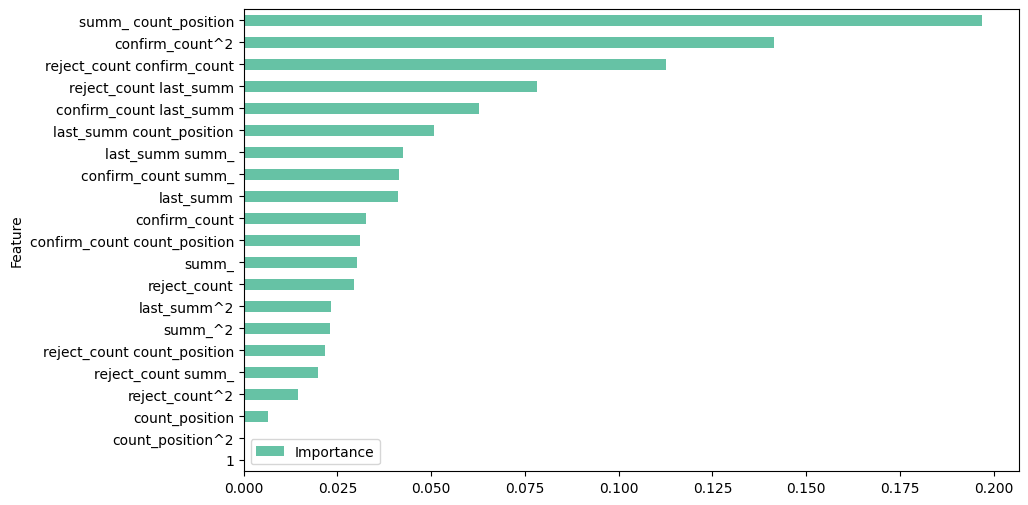

In [ ]:
feature_importance = pd.DataFrame({'Feature': poly.get_feature_names_out(), 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

От лишних признаков стоит избавиться с помощью `SelectKBest`.

Для линейной регрессии вы использовали статистический тест `f_classif`, поскольку оценивали линейное влияние входных признаков на целевой.

Дерево решений не ищет линейные зависимости, поэтому выбираем другой метод — `mutual_info_classif`:

In [51]:
accs_tree = []
money_tree = []

# объявляем селектор
# он будет подбирать разное количество признаков за счёт цикла
# обучим модель с разным числом признаков и сравним их с точностью лучшей модели

for i in range(len(X_test_df.columns)):
    selector = SelectKBest(mutual_info_classif, k=i+1)
    selector.fit(X_train_scalled, y_train)

    features_names = selector.get_feature_names_out()

    X_train_new = X_train_scalled[list(features_names)]
    X_test_new = X_test_scalled[list(features_names)]

    model = DecisionTreeClassifier(class_weight = 'balanced', random_state=RANDOM_STATE)
    model.fit(X_train_new, y_train)

    acc_new = accuracy_score(y_test, model.predict(X_test_new))

    predicts = X_test_df[['summ_']].copy()
    predicts['tree'] = model.predict(X_test_new)
    predicts['y_test'] = y_test.tolist()

    TP = predicts[(predicts['tree']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
    FP = predicts[(predicts['tree']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

    accs_tree.append(acc_new)
    money_tree.append(TP-FP)

    print('Число признаков: ', i+1, 'accuracy_last = ', round(acc1, 5), 'accuracy = ', round(acc_new, 5), 'money = ', round(TP-FP,3))



У дерева решений с 17 признаками качество выше лучшей версии логистической регрессии, при этом оно экономит больше денег.

Какие признаки отобрало дерево решений?

In [51]:
# объявляем селектор
# обучите модель с числом признаков 17 и выводим названия отобранных признаков методом get_feature_names_out()


## Корреляция между метриками и сэкономленными деньгами

Выше мы заметили, что прирост значений метрики не всегда сопровождается большей экономией денег. Разберёмся, почему так.

Для начала нужно посчитать корреляцию Пирсона между `accuracy` и оценкой сберегаемых средств, а затем посмотреть, изменится ли взаимосвязь, если оценивать модель другой метрикой. Также стоит применить эти расчёты к обеим моделям с лучшим качеством: к логистической регрессии и к дереву решений.

Посмотрим на распределение значений логистической регрессии на диаграмме рассеяния:

In [53]:
# строим диаграмму рассеяния между метрикой и сэкономленными деньгами
#sns.set_style('white')

quality = pd.DataFrame()
quality['money'] = money_logreg
quality['accuracy'] = accs_logreg

a = sns.scatterplot(data = quality, x = 'money', y = 'accuracy')

Видим некоторую зависимость. Вычислим коэффициент корреляции:

In [52]:
pearsonr(money_logreg,accs_logreg)[0]

Теперь посмотрим на связь между сэкономленными деньгами и `ROC-AUC`:

In [ ]:
rocs = []
money = []
for i in range(len(X_test_df.columns)):
    selector = SelectKBest(f_classif, k=i+1)
    selector.fit(X_train_scalled, y_train)

    features_names = selector.get_feature_names_out()

    X_train_new = X_train_scalled[list(features_names)]
    X_test_new = X_test_scalled[list(features_names)]

    model = LogisticRegression(class_weight = 'balanced', random_state = RANDOM_STATE)
    model.fit(X_train_new, y_train)

    roc1 = roc_auc_score(y_test.tolist(), model.predict(X_test_new))

    predicts = X_test_df[['summ_']].copy()
    predicts['logreg'] = model.predict(X_test_new)
    predicts['y_test'] = y_test.tolist()

    TP = predicts[(predicts['logreg']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7**0.8
    FP = predicts[(predicts['logreg']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

    rocs.append(roc1)
    money.append(TP-FP)

In [54]:
quality = pd.DataFrame()
quality['money'] =
quality['ROC-AUC'] =

a = sns.scatterplot()

print('Коэффициент корреляции = ', )

Лучше не стало… А что насчёт `F1`-меры?

In [55]:
f1= []
money = []

for i in range(len(X_test_df.columns)):
    selector = SelectKBest(f_classif, k=i+1)
    selector.fit(X_train_scalled, y_train)

    features_names = selector.get_feature_names_out()

    X_train_new = X_train_scalled[list(features_names)]
    X_test_new = X_test_scalled[list(features_names)]

    model = LogisticRegression(class_weight = 'balanced', random_state=RANDOM_STATE)
    model.fit(X_train_new, y_train)

    f1_new = f1_score(y_test, model.predict(X_test_new))

    predicts = X_test_df[['summ_']].copy()
    predicts['logreg'] = model.predict(X_test_new)
    predicts['y_test'] = y_test.tolist()

    TP = predicts[(predicts['logreg']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
    FP = predicts[(predicts['logreg']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

    f1.append(f1_new)
    money.append(TP-FP)

    print('Число признаков: ', i+1, 'f1 = ', round(f1_new, 5), 'money = ', round(TP-FP,3))

Кажется, что прирост стал гораздо более синхронным. Посмотрим, заметна ли разница на графике и по коэффициенту корреляции:

In [56]:
quality = pd.DataFrame()
quality['money'] =
quality['f1'] =

a = sns.scatterplot()
print('Коэффициент корреляции = ', )

Теперь взглянем на то, есть ли такая же взаимосвязь у показателей дерева решений.

Сначала оценим корреляцию между сэкономленными средстами и метрикой `accuracy`.

In [57]:
quality = pd.DataFrame()
quality['money'] =
quality['accuracy'] =

a = sns.scatterplot()
print('Коэффициент корреляции =', )

Теперь посмотрим на корреляцию между метрикой `f1` и сэкономленными деньгами.

In [58]:
f1= []
money = []

for i in range(len(X_test_df.columns)):
    selector = SelectKBest(mutual_info_classif, k=i+1)
    selector.fit(X_train_scalled, y_train)

    features_names = selector.get_feature_names_out()

    X_train_new = X_train_scalled[list(features_names)]
    X_test_new = X_test_scalled[list(features_names)]

    model = DecisionTreeClassifier(class_weight = 'balanced', random_state=RANDOM_STATE)
    model.fit(X_train_new, y_train)

    f1_new = f1_score(y_test, model.predict(X_test_new))

    predicts = X_test_df[['summ_']].copy()
    predicts['tree'] = model.predict(X_test_new)
    predicts['y_test'] = y_test.tolist()

    TP = predicts[(predicts['tree']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
    FP = predicts[(predicts['tree']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

    f1.append(f1_new)
    money.append(TP-FP)

    print('Число признаков: ', i+1, 'f1 = ', round(f1_new, 10), 'money = ', round(TP-FP,3))


Диаграмма рассеяния и коэффициент корреляции:

In [59]:
quality = pd.DataFrame()
quality['money'] =
quality['f1'] =

a = sns.scatterplot()
print('Коэффициент корреляции =', )

Итак, зафиксируем результаты анализа:
* Оптимальный баланс экономии средств, качества модели и количества признаков показала модель дерева решений с 14 признаками.
* Подходящая метрика для задачи — F1-мера.

## Выводы

* Отбор модели и признаков для задачи — это постепенный процесс. Сначала вы обучаете бейзлайн-модель, затем смотрите на её метрики, а потом начинаете искать более надёжные решения, превосходящие базовое по качеству.
* Чтобы качественно отобрать признаки, нужно провести тщательный анализ данных и подобрать подходящие для вашей ситуации инструменты. К примеру, перед использованием регрессий достаточно выявить линейные закономерности, а для других моделей подойдут иные статистические тесты.
* Не всегда базовая метрика будет коррелировать с показателем, который вы должны улучшить, внедрив модель МО. Поэтому всегда уделяйте время подбору метрики, которая будет корректно отражать способность модели решать вашу задачу.